In [9]:
import numpy as np
import xarray as xr
import dask
import xesmf as xe
import os
from glob import glob

### Preliminaries

In [23]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
in_path = '/gpfs/group/kaf26/default/dcl5300/ISIMIP3b_input_climate_data/files/'
out_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/'
quantile_path = '/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/'

In [11]:
###################
# Models
###################
from utils import isimip_ssp_dict

models = list(isimip_ssp_dict.keys())

In [12]:
####################
# File year layout
####################
start_years = [2015] + [yr for yr in range(2021,2101,10)]
year_steps = [5] + [9 for yr in range(2021,2101,10)]

In [13]:
###################
# Model details
###################
model_info = {}
for model in models:
    tmp = glob(in_path + model.lower() + '*_w5e5_ssp126_pr_global_daily_2015_2020.nc')
    tmp = tmp[0].replace(in_path + model.lower() + '_', '').replace('_w5e5_ssp126_pr_global_daily_2015_2020.nc', '')
    model_info.update({model: tmp})

In [6]:
############
# Dask
############
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, resource_spec='pmem=40GB', memory='40GB',
                     worker_extra_args= ['#PBS -l feature=rhel7'], walltime = '02:00:00')

cluster.scale(jobs=9)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.239:45620,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Simple metrics (no historical quantiles required)

In [7]:
########################################################
# Calculate the metric for a 
# single model-year, including all SSPs and variables
########################################################
def model_year_metric(path, model, model_vers, ssps, var_ids, year, year_step, metric):
    # Function for longest consecutive spell if needed
    def n_longest_consecutive(ds, dim='time'):
        ds = ds.cumsum(dim=dim) - ds.cumsum(dim=dim).where(ds == 0).ffill(dim=dim).fillna(0)
        return ds.max(dim=dim)

    # Set up dictionary for all results
    ds_all = {}
    # Loop through SSPs
    for ssp in ssps:
        # Temporary list for each SSP
        ds_list = []
        # Loop through variables
        for var in var_ids:
            ## Temporary file for each variable
            ds_tmp = xr.open_dataset(path + model + '_' + model_vers + '_w5e5_' + 
                                     ssp + '_' + var + '_global_daily_' + str(year) 
                                     + '_' + str(year + year_step) + '.nc')
            
            ## Convert units
            # temperature: K -> C
            if var == 'tas' and ds_tmp.tas.attrs['units'] == 'K':
                ds_tmp['tas'] = ds_tmp['tas'] - 273.15
            if var == 'tasmax' and ds_tmp.tasmax.attrs['units'] == 'K':
                ds_tmp['tasmax'] = ds_tmp['tasmax'] - 273.15
            if var == 'tasmin' and ds_tmp.tasmin.attrs['units'] == 'K':
                ds_tmp['tasmin'] = ds_tmp['tasmin'] - 273.15

            # precip: kg m-2 s-1 -> mm day-1
            if var == 'pr' and ds_tmp.pr.attrs['units'] == 'kg m-2 s-1':
                ds_tmp['pr'] = ds_tmp['pr'] * 86400

            # Calculate metric
            if metric == 'avg':
                ds_tmp = ds_tmp.resample(time='1Y').mean()
            elif metric == 'max':
                ds_tmp = ds_tmp.resample(time='1Y').max()
            elif metric == 'dry':
                # Number of dry days
                ds_tmp_0 = (ds_tmp == 0.).resample(time='1Y').sum() # 0mm
                ds_tmp_1 = (ds_tmp < 1.).resample(time='1Y').sum() # less than 1mm
                # Longest sonsecutive dry day streak
                ds_tmp_0c = (ds_tmp == 0.).resample(time='1Y').apply(n_longest_consecutive) # 0mm longest consecutive
                ds_tmp_1c = (ds_tmp < 1.).resample(time='1Y').apply(n_longest_consecutive) # less than 1mm longest consecutive
                # Merge
                ds_tmp = xr.merge([ds_tmp_0.rename({'pr':'count_eq_0'}),
                                   ds_tmp_0c.rename({'pr':'streak_eq_0'}),
                                   ds_tmp_1.rename({'pr':'count_lt_1'}),
                                   ds_tmp_1c.rename({'pr':'streak_lt_1'})])
                
            # Append to list
            ds_list.append(ds_tmp)
            
        # Append to dict
        ds_all.update({ssp: ds_list})

    # Merge and concat along ssp dimension
    for ssp in ssps:
        ds_all[ssp] = xr.merge(ds_all[ssp])
        ds_all[ssp] = ds_all[ssp].assign_coords(ssp = ssp)
    
    # Return
    ds_out = xr.concat([ds_all[ssp] for ssp in ssps], dim='ssp')
    return ds_out

### Annual averages

In [22]:
# Loop through models: RUNTIME IS ~10 MINS PER MODEL WITH 9 DASK WORKERS
metric = 'avg'

# All variables
var_ids = ['tas', 'tasmin', 'tasmax', 'pr']

for model in models:
    # Check if already exists
    if os.path.isfile(out_path + 'native_grid/' + metric + '/' + model + '.nc'):
        print(model + ' already done')
        continue
    
    # Parallelize with dask over years
    delayed_res = []

    for year, year_step in zip(start_years, year_steps):
        tmp_res = dask.delayed(model_year_metric)(path = in_path,
                                                  model = model.lower(),
                                                  model_vers = model_info[model],
                                                  ssps = isimip_ssp_dict[model],
                                                  var_ids = var_ids,
                                                  year = year, 
                                                  year_step = year_step,
                                                  metric = metric)
        delayed_res.append(tmp_res)
            
    # Compute
    res = dask.compute(*delayed_res)

    # Store
    df_final = xr.combine_by_coords(res)
    df_final.to_netcdf(out_path + 'native_grid/' + metric + '/' + model + '.nc')

    print(model)

CanESM5 already done
CNRM-CM6-1 already done
CNRM-ESM2-1 already done
EC-Earth3 already done
GFDL-ESM4 already done
IPSL-CM6A-LR already done
MIROC6 already done
MPI-ESM1-2-HR already done
MRI-ESM2-0 already done
UKESM1-0-LL already done


### Annual maxima

In [23]:
metric = 'max'

# All variables
var_ids = ['tas', 'tasmin', 'tasmax', 'pr']

for model in models:
    # Check if already exists
    if os.path.isfile(out_path + 'native_grid/' + metric + '/' + model + '.nc'):
        print(model + ' already done')
        continue
    
    # Parallelize with dask over years
    delayed_res = []

    for year, year_step in zip(start_years, year_steps):
        tmp_res = dask.delayed(model_year_metric)(path = in_path,
                                                  model = model.lower(),
                                                  model_vers = model_info[model],
                                                  ssps = isimip_ssp_dict[model],
                                                  var_ids = var_ids,
                                                  year = year, 
                                                  year_step = year_step,
                                                  metric = metric)
        delayed_res.append(tmp_res)
            
    # Compute
    res = dask.compute(*delayed_res)

    # Store
    df_final = xr.combine_by_coords(res)
    df_final.to_netcdf(out_path + 'native_grid/' + metric + '/' + model + '.nc')

    print(model)

CanESM5 already done
CNRM-CM6-1 already done
CNRM-ESM2-1 already done
EC-Earth3 already done
GFDL-ESM4 already done
IPSL-CM6A-LR already done
MIROC6 already done
MPI-ESM1-2-HR already done
MRI-ESM2-0 already done
UKESM1-0-LL already done


### Dry days

In [8]:
# Loop through models: RUNTIME IS ~10 MINS PER MODEL WITH 9 DASK WORKERS
metric = 'dry'

# Precip only
var_ids = ['pr']

for model in models:
    # Check if already exists
    if os.path.isfile(out_path + 'native_grid/' + metric + '/' + model + '.nc'):
        print(model + ' already done')
        continue
    
    # Parallelize with dask over years
    delayed_res = []

    for year, year_step in zip(start_years, year_steps):
        tmp_res = dask.delayed(model_year_metric)(path = in_path,
                                                  model = model.lower(),
                                                  model_vers = model_info[model],
                                                  ssps = isimip_ssp_dict[model],
                                                  var_ids = var_ids,
                                                  year = year, 
                                                  year_step = year_step,
                                                  metric = metric)
        delayed_res.append(tmp_res)
            
    # Compute
    res = dask.compute(*delayed_res)

    # Store
    df_final = xr.concat(res, dim='time')
    df_final.to_netcdf(out_path + 'native_grid/' + metric + '/' + model + '.nc')

    print(model)

CanESM5 already done
CNRM-CM6-1 already done
CNRM-ESM2-1 already done
EC-Earth3 already done
GFDL-ESM4
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MRI-ESM2-0
UKESM1-0-LL


## Less simple metrics (historical quantiles required)

In [76]:
def model_year_ssp_metric(model_path, quantile_path, model, model_vers, ssp, var_id, year, year_step, obs):
    """
    Reads ISIMIP model output for a given ssp-year and calculates the number of hot/wet days 
    and the longest consecutive hot/wet day streak. This function will be wrapped in dask 
    distributed.
    """
    
    # Subfunction to calculate longest consecutive spell
    def n_longest_consecutive(ds, dim='time'):
        ds = ds.cumsum(dim=dim) - ds.cumsum(dim=dim).where(ds == 0).ffill(dim=dim).fillna(0)
        return ds.max(dim=dim)
    
    # Read historical quantiles
    if var_id in ['tasmax', 'tasmin', 'tas']:
        if 'gmfd' in obs:
            ds_q_gmfd = xr.open_dataset(quantile_path + 'gmfd_temperature_quantiles_isimip.nc')
        if 'era5' in obs:
            ds_q_era5 = xr.open_dataset(quantile_path + 'era5_temperature_quantiles_isimip.nc')
    elif var_id == 'pr':
        if 'gmfd' in obs:
            ds_q_gmfd = xr.open_dataset(quantile_path + 'gmfd_precip_quantiles_isimip.nc')
        if 'era5' in obs:
            ds_q_era5 = xr.open_dataset(quantile_path + 'era5_precip_quantiles_isimip.nc')
    
    # Read model file
    ds_tmp = xr.open_dataset(model_path + model + '_' + model_vers + '_w5e5_' + 
                             ssp + '_' + var_id + '_global_daily_' + str(year) 
                             + '_' + str(year + year_step) + '.nc')

    ds_tmp = ds_tmp.sel(lat=slice(90,-60)) # both obs extend only to 60S
           
    # Temperature: K -> C
    if var_id == 'tas' and ds_tmp.tas.attrs['units'] == 'K':
        ds_tmp['tas'] = ds_tmp['tas'] - 273.15
    if var_id == 'tasmax' and ds_tmp.tasmax.attrs['units'] == 'K':
        ds_tmp['tasmax'] = ds_tmp['tasmax'] - 273.15
    if var_id == 'tasmin' and ds_tmp.tasmin.attrs['units'] == 'K':
        ds_tmp['tasmin'] = ds_tmp['tasmin'] - 273.15

    # Precip: kg m-2 s-1 -> mm day-1
    if var_id == 'pr' and ds_tmp.pr.attrs['units'] == 'kg m-2 s-1':
        ds_tmp['pr'] = ds_tmp['pr'] * 86400

    # Calculate metrics
    ds_tmp_out = []
    for rp in ['rp5', 'rp10', 'rp20']:
        # GMFD
        if 'gmfd' in obs:
            # Above/below binary
            ds_tmp_q_gmfd = ds_tmp[var_id] > ds_q_gmfd[var_id + '_' + rp]
            # Count
            ds_tmp_q_gmfd_count = ds_tmp_q_gmfd.resample(time='1Y').sum()
            ds_tmp_out.append(xr.Dataset({var_id + '_' + rp + 'gmfd_count': ds_tmp_q_gmfd_count}))
            # Streak
            ds_tmp_q_gmfd_streak = ds_tmp_q_gmfd.resample(time='1Y').apply(n_longest_consecutive)
            ds_tmp_out.append(xr.Dataset({var_id + '_' + rp + 'gmfd_streak': ds_tmp_q_gmfd_streak}))
            
        # ERA5
        if 'era5' in obs:
            # Above/below binary
            ds_tmp_q_era5 = ds_tmp[var_id] > ds_q_era5[var_id + '_' + rp]
            # Count
            ds_tmp_q_era5_count = ds_tmp_q_era5.resample(time='1Y').sum()
            ds_tmp_out.append(xr.Dataset({var_id + '_' + rp + 'era5_count': ds_tmp_q_era5_count}))
            # Streak
            ds_tmp_q_era5_streak = ds_tmp_q_era5.resample(time='1Y').apply(n_longest_consecutive)
            ds_tmp_out.append(xr.Dataset({var_id + '_' + rp + 'era5_streak': ds_tmp_q_era5_streak}))
    
    # Merge and return
    ds_out = xr.merge(ds_tmp_out)
    ds_out = ds_out.assign_coords(ssp=ssp)
    return ds_out

In [77]:
model

'UKESM1-0-LL'

In [ ]:
%%time
out = model_year_ssp_metric(in_path,
                      quantile_path,
                      model.lower(),
                      model_info[model],
                      isimip_ssp_dict[model][0],
                      'tasmin',
                      start_years[0],
                      year_steps[0],
                      ['era5'])

In [51]:
out

<xarray.Dataset>
Dimensions:             (lon: 720, lat: 360, time: 6)
Coordinates:
  * lon                 (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat                 (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time                (time) datetime64[ns] 2015-12-31 ... 2020-12-31
    ssp                 <U6 'ssp126'
Data variables:
    pr_rp5gmfd_count    (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp5gmfd_streak   (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0
    pr_rp5era5_count    (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp5era5_streak   (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0
    pr_rp10gmfd_count   (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp10gmfd_streak  (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0
    pr_rp10era5_count   (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp10era5_streak  (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0
    pr_rp20gmfd_count   (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp20gmfd_streak  (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0
    pr_rp20era5_count   (time, lat, lon) int64 36 35 39 39 37 37 ... 0 0 0 0 0 0
    pr_rp20era5_streak  (time, lat, lon) float64 3.0 3.0 4.0 4.0 ... 0.0 0.0 0.0

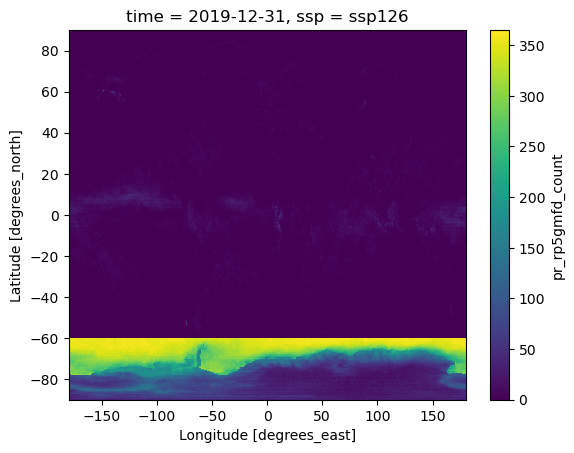

In [53]:
out.isel(time=4).pr_rp5gmfd_count.plot()